# FEniCS simulation of a cantilever beam

The aim of this notebook is to setup a very simple FEniCS simulation. The framework is linear, plane strain elasticity. We model a cantilever beam ($L$: total length; $d$: depth), subjected to its own weight ($\rho$: mass density per unit volume; $g$: gravity) and tractions $\bar T$ applied to the right end.

The beam is homogenous and isotropic ($E$: Young modulus; $\nu$: Poisson ratio) and clamped on the left end. Hooke's law reads

\begin{equation}
\sigma_{ij} = \lambda\varepsilon_{kk}\delta_{ij}+2\mu\varepsilon_{ij},
\end{equation}

where indices $i, j, k$ are restricted to $\{1, 2\}$ and $\lambda$, $\mu$ are the Lamé coefficients :

\begin{equation*}
\mu=\frac{E}{2\bigl(1+\nu\bigr)}
\quad\text{and}\quad
\lambda=\frac{2\mu\nu}{1-2\nu}.
\end{equation*}

**Question:** how does Hooke's law read in *plane stress* elasticity?

The variational formulation of the problem is the following:

Find $u\in \mathcal{C}\equiv\{u: H^1(\Omega), \; u(x_1=0,x_2)=0\}$ such that 
$\forall v\in \mathcal{C}_0\equiv \mathcal{C}$


\begin{equation}
\int_\Omega \sigma(\varepsilon(u)):\varepsilon(v)\,\mathrm{d}x\,\mathrm{d}y =
\int_{\partial\Omega\cap\{x=\ell\}}\overline{T}\cdot v\,\mathrm{d} y
-\int_{\Omega}\rho g\,e_y\cdot v\,\mathrm{d} x\,\mathrm{d} y,
\end{equation}

where $\sigma(\varepsilon)$ is the constitutive equation and $\varepsilon(u)=\mathrm{sym} (\nabla u)$  

In [2]:
import dolfin
import matplotlib.pyplot as plt
import numpy as np

## geometry and mesh

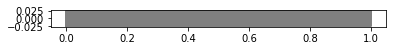

In [3]:
# geometry and mesh 
L = 1.0
d = L/20.
h = d/16.
mesh= dolfin.RectangleMesh(dolfin.Point(0., -0.5*d), dolfin.Point(L, 0.5*d), int(L/h), int(d/h))
dolfin.plot(mesh)

## variational formulation

In [4]:
# variational formulation
#element = dolfin.VectorElement('P', cell=mesh.ufl_cell(), degree=degree, dim=mesh.geometric_dimension()
V = dolfin.VectorFunctionSpace(mesh, 'P',1,dim=2)

The strain-displacement operator is the operator $u_i\mapsto\frac12\bigl(\partial_i u_j+\partial_j u_i\bigr)$, where $u_i$ are the components of the displacement. FEniCS implementation is straightforward.

In [5]:
# eps(u)
def strain_displacement(u):
    return dolfin.sym(dolfin.grad(u))

In [6]:
E = 1.0
nu = 0.3

I2 = dolfin.Identity(mesh.geometric_dimension())
mu = dolfin.Constant(E/2./(1.+nu))
lamb = dolfin.Constant(E*nu/(1.+nu)/(1.-2.*nu))

# Hook's law
def stress_strain(eps):
    return lamb*dolfin.tr(eps)*I2+2*mu*eps

In [7]:
u = dolfin.TrialFunction(V)
v = dolfin.TestFunction(V)

\begin{equation}
\int_\Omega \sigma(\varepsilon(u)):\varepsilon(v)\,\mathrm{d}x\,\mathrm{d}y
\end{equation}

In [8]:
bilinear_form = dolfin.inner(stress_strain(strain_displacement(u)),
                             strain_displacement(v))*dolfin.dx

\begin{equation}
-\int_{\Omega}\rho g\,e_y\cdot v\,\mathrm{d} x\,\mathrm{d} y.
\end{equation}

In [27]:
g = 1.
body_forces = dolfin.Constant((0., g))
linear_form = dolfin.dot(body_forces, v)*dolfin.dx

## Boundary conditions

In [10]:
atol = 1e-8*h

In [11]:
def left(x, on_boundary):
    return on_boundary and x[0] <= atol

In [12]:
#u_prescribed = dolfin.Constant((0., 0.))
bcond = dolfin.DirichletBC(V, (0.0,0.0), left)

## Solving the discretized problem

In [13]:
usol = dolfin.Function(V)

In [14]:
dolfin.solve(bilinear_form == linear_form, usol, bcond)

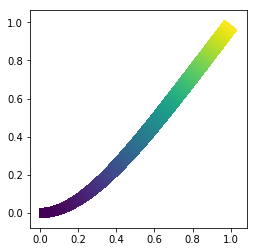

In [15]:
D=E*d**3/12./(1.-nu**2)
vmax=1/8*g*d/D # theorie de poutre linaire : 1/8 Gamma
dolfin.plot(usol/vmax, mode='displacement')

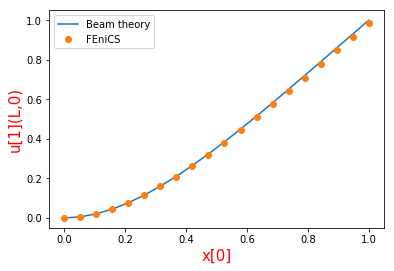

In [18]:
x = np.linspace(0., L, num=20)
v_fem = [usol(x_i, 0.0)[1]/vmax for x_i in x]
v_fem = np.array(v_fem)

#v_beam = (2.*x**2 - 4./3.*x**3 + x**4/3.) # c'est pareil
v_beam = (1./3.*(x-1.)**4 + 4./3.*x - 1/3)

plt.plot(x, v_beam, label='Beam theory')
plt.xlabel('x[0]',color='red',fontsize=15)
plt.ylabel('u[1](L,0)',color='red',fontsize=15)
plt.plot(x, v_fem, 'o', label='FEniCS')
plt.legend()

In [26]:
usol(0.1, 0.01)

array([-1.92408524, 10.18081364])